# NIFITS: application to LBTI nullin

## Perimeter
This work serves as a an exploration proof of concept to demonstrate how NIFITS models can operate at the frontier between continuous and discrete pupils, using the subaperture modelling.

## Tools
We import different modules to help in the managing of different data.

* `xaosim` can be used to create some synthetic pupils. Here, the LBTI pupil will be used instead.
* `xara` and `saro` are kernel-phase data analysis packages meant for the analysis of continuous/arbitrary pupils.
  We will use them to create discrete sub-aperture arrays, based on pupil mask definition.
* `PIL` PILLOW is used to load the png initial image used as a reference pupil and later converted to numpy array.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it.
from IPython.core.display import HTML
css_file = '/home/romain/Downloads/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())



In [2]:
import xaosim

XAOSIM version  2.0.0


In [3]:
import xara
import saro
import numpy as np
import matplotlib.pyplot as plt

### Creation of the LBT pupil map
The pupil map is created based on data provided by the consortium. It was built for the example and should not serve as reference.

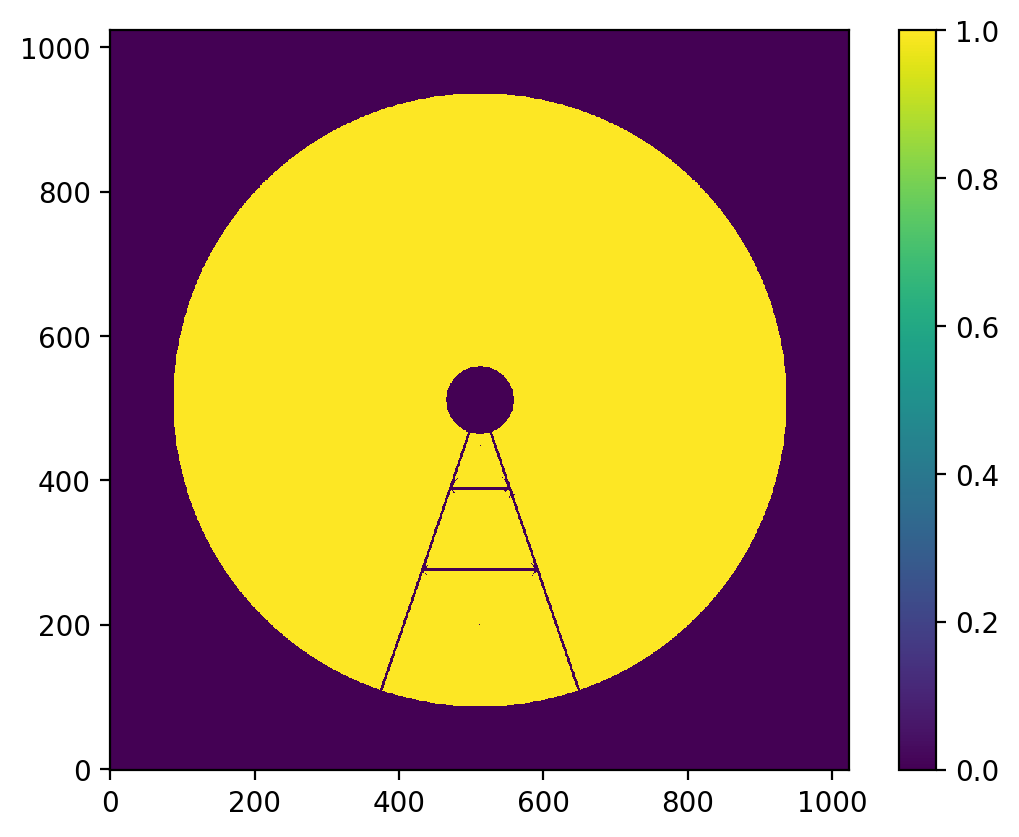

In [4]:
from PIL import Image
# 1024x1024 pix, 0.009732 m/pix
bitmap_lbt = Image.open("lbti_data/bitmap_lbt_pupil.png")
apup = np.flip(np.asarray(bitmap_lbt)[:,:,0]>=1, axis=0)
plt.figure(dpi=200)
plt.imshow(apup[:,:])
plt.colorbar()

### The binocular pupil
A model of the full Fizeau pupil is created as it is used to collect photons. Here, we simplify the operation by using integer pixel shift, which afords a precision of ~10mm. This is sufficient for the sake of the demo, but in practice, one should take care of making this operation more accurate, e.g. by choosing a pixel size that makes this operation correct, or by using a frequency space shift.

In [5]:
# apup = xaosim.pupil.four_spider_mask(500, 500, 200, 8.4, 1.1, beta=50.,thick=0.2, offset=0.3)
ppscale = 0.009732 # m/pix
bpup = np.pad(apup, (800))
cpup = np.roll(bpup, int(np.round((14.4/2/ppscale)))) + np.roll(bpup, int(np.round(-14.4/2/ppscale)))

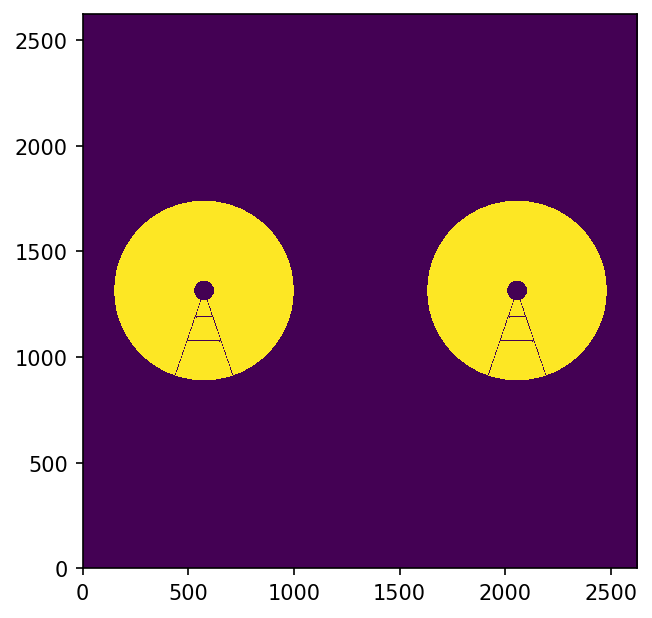

In [6]:
plt.figure(dpi=150)
plt.imshow(1*cpup)
plt.show()

### Discrete model creation
A disccrete array is created based on this high resolution mask. This operation follows the recommendations given by Martinache 2019 for the improved accuracy of such models. The scipt `create_discrete_model` rovided in xara. This takes in 
* a model pitch size `step`,
* the pupil pixel scale `ppscale` in m/pix,
* `binary` which dictate whether to enable the use of partially trasmitting subapertures,
* `tmin` which gives a threshold to discard the subapertures having the lowest transmission.

This returns `model`, an array of x, y and transmission for each subaperture.

The created model is stored into a `kpo.kpi` object for pure convenience. `kpi` has a plotting method to plot the pupil and UV map.

In [7]:
model = xara.create_discrete_model(apert=cpup,step=0.40, #0.30
                                ppscale=ppscale, binary=False, tmin=0.2)

Attempting to build KPI from array
1936 distinct baselines were identified
first 10 singular values for this array:
[305.97411 290.70147 289.66942  88.46446  86.85296  81.71363  81.43862
  79.36997  78.04104  64.71717]
<xara.kpi.KPI object at 0x7f12954ef910> KPI data structure
----------------------------------------
-> 696 sub-apertures
-> 1936 distinct baselines
-> 1241 Ker-phases ( 64.1 % target phase)
-> 695 Eig-phases (100.0 % wavefront phase)
----------------------------------------

KPI data successfully created
No KPO data included


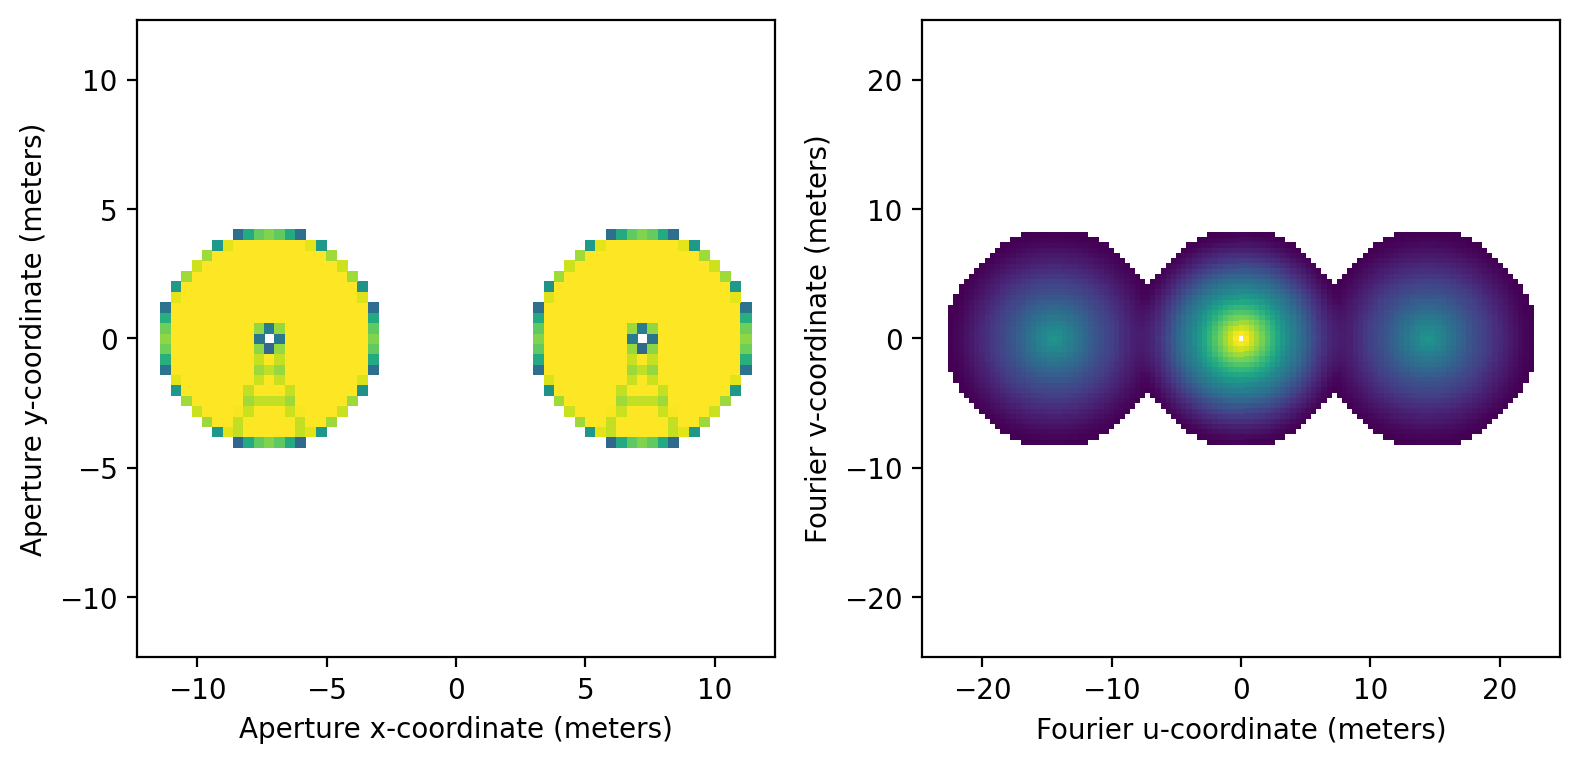

In [8]:
mykpo = saro.KPO(array=model, )
mykpo.CWAVEL = 10.0e-6
dump = mykpo.kpi.plot_pupil_and_uv(cmap="viridis", usesize=False, ssize=4., marker="s")
# dump = mykpo.kpi.plot_pupil_and_uv(cmap="viridis", usesize=True, ssize=3., marker="s",)
collectors = mykpo.kpi.VAC

![title](nomic_principle.png)

### Nature of the pupil
Here, the interferometric baseline of 14.4 m is not much larger than the diameter of 8.25 m of each aperture. This means that the resolving power of each collector is close to that of the array, and **accounting for the diffraction of in each collector is important in transfer function of the instrument.** We can even see that some of the baselines present between the pupils are already present inside a single pupil.

## Construction of the transfer model

NIFITS relies on an algebraic representation of the interferometer in which the light combination is obtained by taking the vector of complex electric field collected at the inputs, multiplying each element by a complex phasor (to represent possible modulations) and multiplying that vector by a complex matrix $\mathbf{M}_{CATM}$ to obtain the complex amplitude present on the detector.

$$\mathbf{e}_{collected} = \mathbf{c}(x,y,\lambda) \circ \mathbf{e} \tag{1} $$

In LBTI/NOMIC, the beam combination is done by a bulk-optics. The two pupils are relatively phased by $\pi/2$ with an optical delay, then are superimposed with a beamsplitter.

![Schematic of the NOMIC combiner](nomic_principle.png)
### Fig 1.: The NOMIC beam combiner (Defrere et al. 2016)

In order to leverage the full sensitivity, the combined pupil is focused onto the detector. It has traits of different types of beam-combiners:
* Michelson (/Mach-Zehnder) recombination of individual beams since the pupils are superimposed,
* Fizeau recombination as the sub-apertures of each beam are interfered through Fraunhofer interference.
* pupil-remapping Fizeau (multiaxial) beam-combiner.

This last description is better describing the operation. This can be modeled by a direct Fraunhofer propagation of a new pupil which is composed of the two initial pupils superimposed on top of one another. The superimposed pupil `U` can be created based ont he initial array `collectors` as follows:

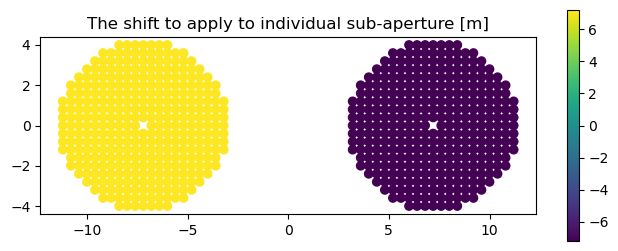

In [10]:
pmask_right = collectors[:,0]>=0
U_shift = np.zeros_like(collectors[:,:2])
U_shift[pmask_right] += np.array((-14.4/2, 0.))
U_shift[np.logical_not(pmask_right)] += np.array((+14.4/2, 0.))
U = collectors[:,:2] + U_shift

plt.figure(figsize=(8,3))
plt.scatter(collectors[:,0], collectors[:,1], c=U_shift[:,0])
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The shift to apply to individual sub-aperture [m]")
plt.show()

## Phase-shifting

Here, a achromatic phase shifting vector `cpx_mask` is created.

In [11]:
cpx_mask = np.ones(collectors.shape[0], dtype=np.complex64)
cpx_mask[pmask_right] = np.exp(1j*np.pi)

## Beam-combination matrix
The Fraunhoffer diffraction boils down to a Fourier transform. Discrete Fourier transforms can be computed with different recipes. A convenient one was proposed by 
A matrix operation for the beam-combination operation is described by [Soummer 2007](https://ui.adsabs.harvard.edu/link_gateway/2007OExpr..1515935S/doi:10.1364/OE.15.015935) using a pair of matrices $\mathbf{E}_1$ and $\mathbf{E}_2$ multiplied on either side of the 2D data $\mathbf{f}$.
$$\mathbf{F} = \mathbf{E}_1 \cdot \mathbf{f} \cdot \mathbf{E}_2 \tag{2}$$
Here each matrix conveniently operates the Fourier transform along one of the axes of the data array. It exploits the fact the Fourier transform is *separable* to do the operation in two steps.

If we so-desire, the operation can be done in a single step, with a single matrix. For this, the data is flattened into a long vector, and a single matrix is written in the fashion of (10) and (11) of Soummer 2007 using both coordinates.

In [12]:
def get_single_matrix_FT(U, X, lamb, sign=-1):
    """
    **Arguments** :
    U         : 2D coordinates in the starting plane
    X         : 2D coordinates in the arrival plane
    f         : The focal length of the system [m]
    """
    i2pi = 1j*2*np.pi
    coeff = 1/(U.shape[0]*X.shape[0])
    Z = np.einsum("P d, i d -> P i", U, X).T
    # Z = np.outer(U.T, X)
    Z.shape
    C = coeff*np.exp(sign*i2pi/lamb * Z)
    return C
def get_dual_matrix_FT(U, X, lamb, sign=-1):
    """
    **Arguments** :
    U         : 2D coordinates in the starting plane
    X         : 2D coordinates in the arrival plane
    f         : The focal length of the system [m]
    """
    i2pi = 1j*2*np.pi
    coeff = 1/(U.size*X.shape[0]*u.shape[1])
    Z0 = U[:,0].outer(X[0,:,0])
    Z1 = U[:,1].outer(X[:,0,1])
    # Z = np.outer(U.T, X)
    Z.shape
    C0 = coeff*np.exp(sign*i2pi/lamb * Z0)
    C0 = coeff*np.exp(sign*i2pi/lamb * Z1)
    return C

## Numerical application:
Here, we bypass the beam-compression operation that is done before entering the instrument, using the size of the initial pupil and the equivalent total focal length. Here we assume an approximate focal length of 50m and a pixel pitch of 50µm. We compute an array of 100x100 pixels.

0.00025


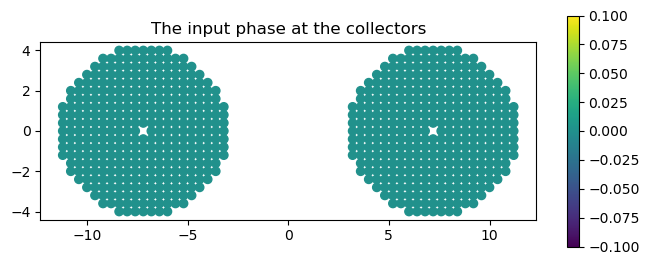

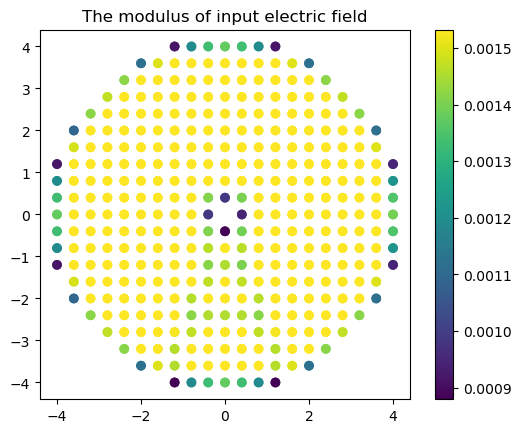

In [13]:
f = 50.
res = 100
pixel_pitch = 5.0e-6
halfwidth = pixel_pitch*res/2
det_extent = [-halfwidth, halfwidth, -halfwidth, halfwidth]
print(halfwidth)
xx, yy = np.meshgrid(np.linspace(-halfwidth, halfwidth, res), np.linspace(-halfwidth, halfwidth, res))
X = 1/f * np.concatenate((xx.flatten()[:,None], yy.flatten()[:,None]), axis=1)




C = get_single_matrix_FT(U, X, lamb=10.0e-6, sign=-1)
C = (C).astype(np.complex64)
tot_amp = np.sum(collectors[:,2])
x = np.sqrt(collectors[:,2])/tot_amp
g = C.dot(x)


plt.figure(figsize=(8,3))
plt.scatter(collectors[:,0], collectors[:,1], c=np.angle(x))
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The input phase at the collectors")
plt.show()

plt.figure()
plt.scatter(U[:,0], U[:,1], c=np.abs(x))
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The modulus of input electric field")
plt.show()



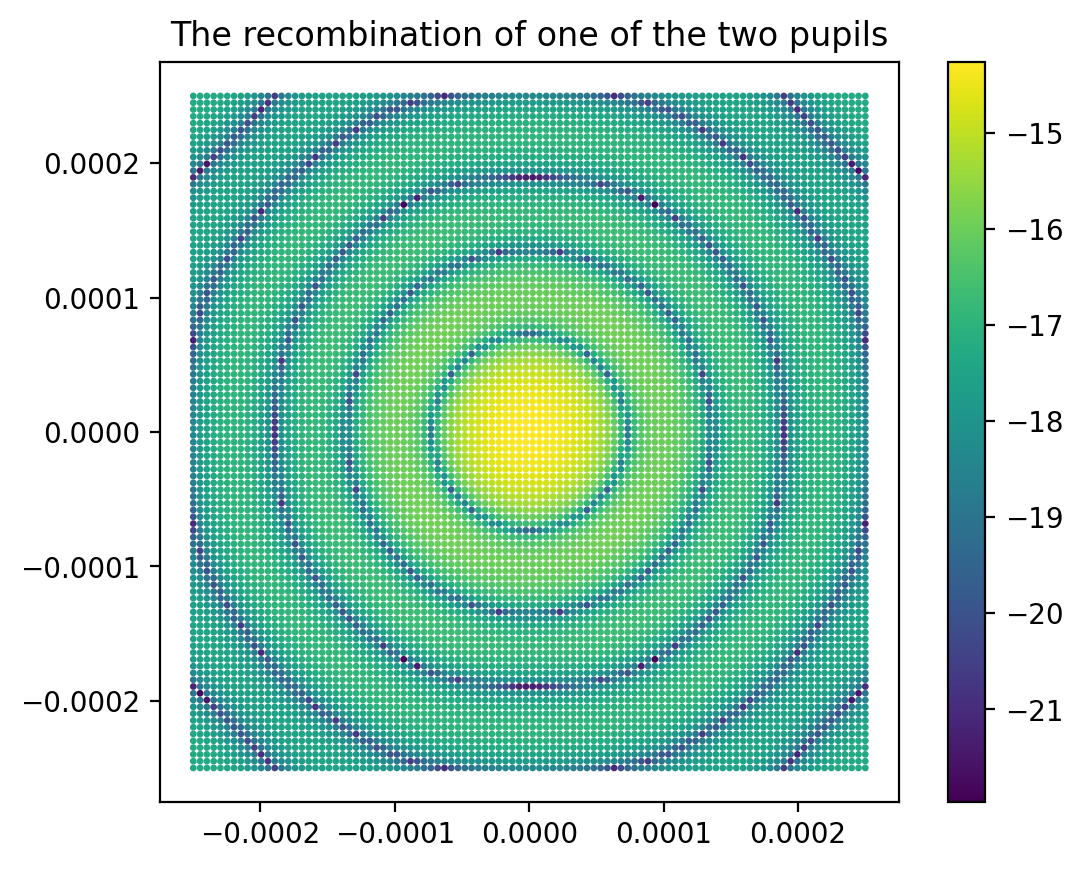

In [14]:
g1 = C[:,pmask_right].dot(x[pmask_right])
plt.figure(dpi=200)
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.abs(g1)**2), s=2.)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The recombination of one of the two pupils")
plt.show()

3.766893482756091e-12


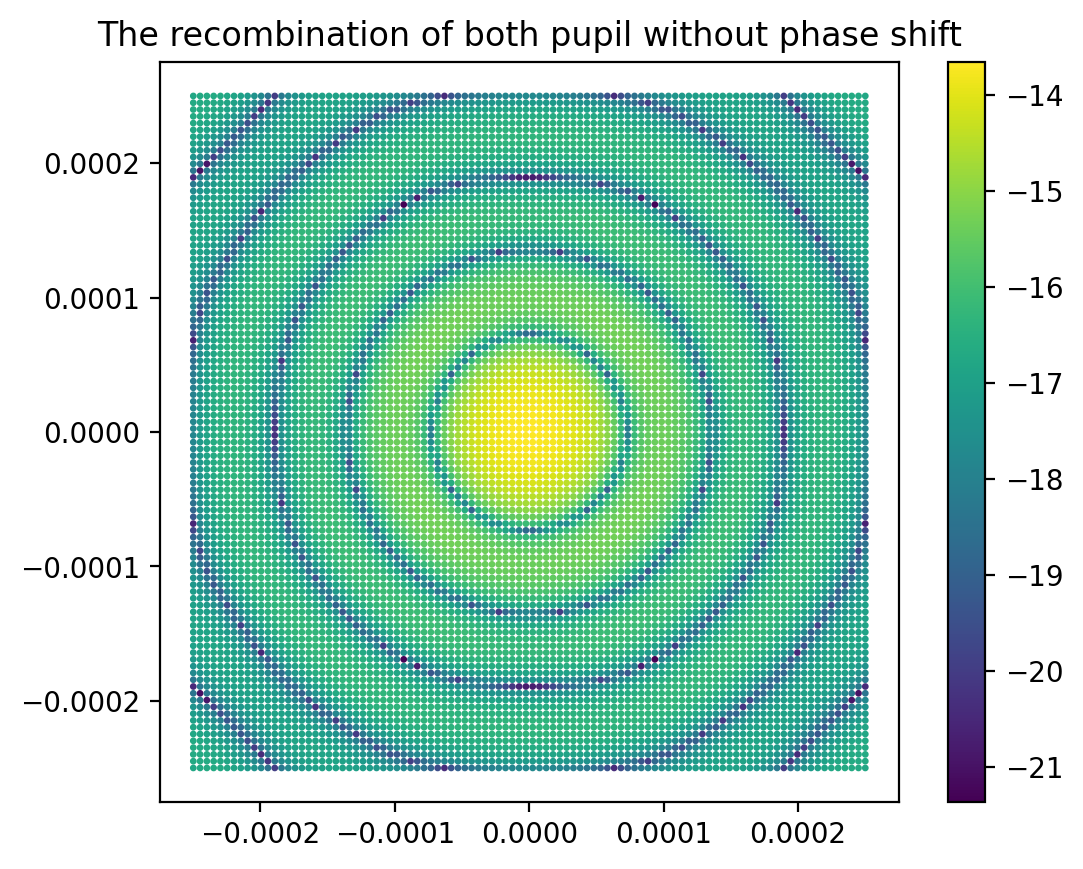

In [15]:
g2 = C.dot(x)
print(np.sum(np.abs(g2**2)))
plt.figure(dpi=200)
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.abs(g2)**2), s=2.)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The recombination of both pupil without phase shift")
plt.show()

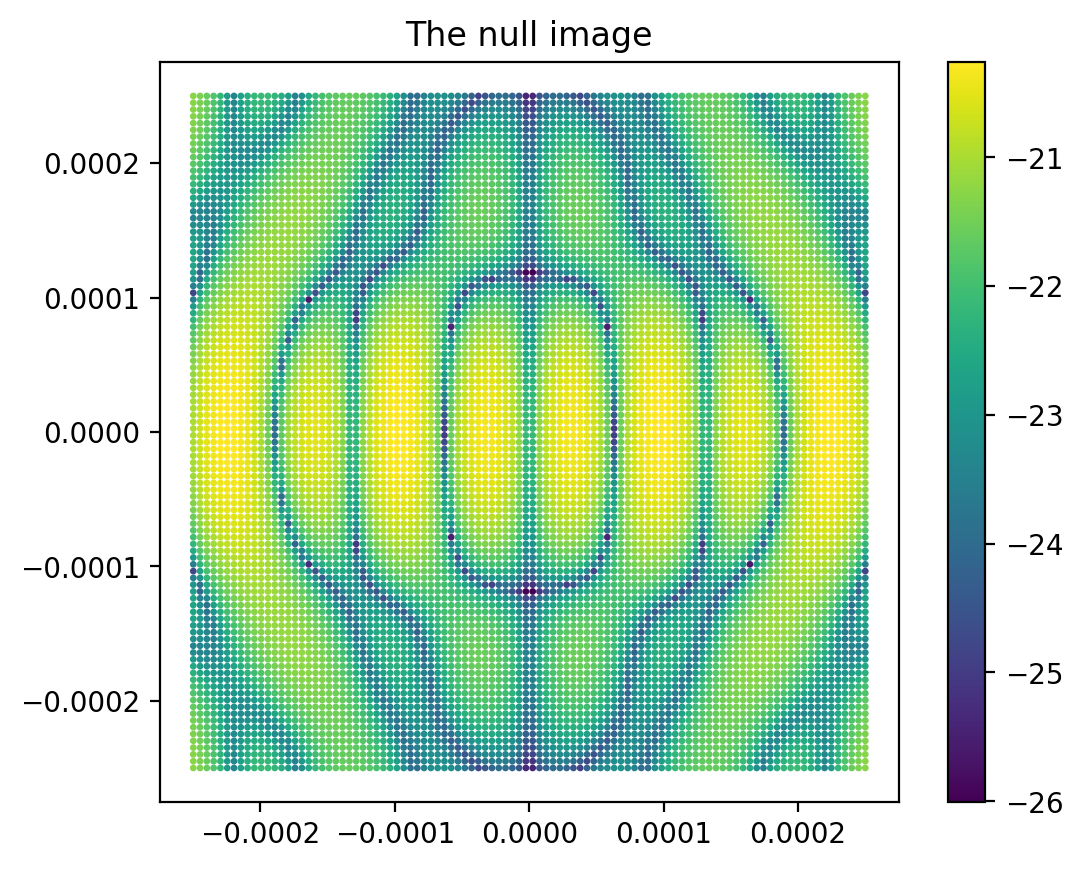

In [16]:
gn = C.dot(x * cpx_mask.T)
plt.figure(dpi=200)
plt.scatter(xx.flatten(), yy.flatten(), c=np.log10(np.abs(gn)**2), s=2.)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.title("The null image")
plt.show()

## Null leakage

Here, we can see that some leakage is present. It seems to come from the inperfect alignment of the pupils we created, due to the integer pixel shifting of the pupil images. We can estimate the resulting null depth:

In [17]:
null_depth = np.sum(np.abs(gn)**2)/np.sum(np.abs(g2)**2)
print(f"{null_depth:.4e}")

1.6645e-06


## Size considerations
With this type of computation, the array size can be a significant concern. Here, we switch to single precision complex numbers (`np.complex64`) instead of the default (`np.complex128`). With our operation, we have a matrix which is 53MB. Acouple of of choices can be made:

1. Single precision float (Already implemented)
2. Discard the corners of the array by discarding the relevant rows of the matrix for a gain of $\pi/4$ in size.
3. Revert to a 2 matrix operation. This would change the size from $n_i \times n_o$ into a size of $n_{xi} n_{xo} + n_{yi} n_{yo}$. For the typical square configuration of arrays, that is : $2*(n_i/2 * n_o/2)$ so a factor 2 in memory.

In [ ]:
n_i = U.shape[0]
n_o = xx.flatten().shape[0]
print(f"Transfer matrix from {n_i} pupils to {n_o} pixels")

In [ ]:
print(f"Memory footprint: {C.__sizeof__()/(2**20):.2f} MB with {C.dtype}")
import timeit
thetime = timeit.timeit("I = C.dot(x)", globals=globals(), number=1000)
print(thetime)

In [ ]:
result = %timeit -o I = C.dot(x)

In [ ]:
cpx_mask.__sizeof__()

## Null values
Currently the data reduction pipeline of LBTI extracts aperture photometry of the main spot of the system. This can be obtained usning the K matrix. A matrix can be constructed to sum the values of pixels in different concentric regions. One can use this as the main observables in the interpretation.

In NIFITS we can go further by considering sectors rather than annuli, and start considering the possibility of inclined disks VS face-on disks, or the astrometry of an off-axis source.

In [ ]:

def get_pupil_shift_matrix(U, shift, mask):
    U[mask] = U[mask]+shift
    return U